In [1]:
%load_ext autoreload
%autoreload 2

## Build your own CNN

### cnn bp check

In [2]:
%run test_grad.py

w error: 2.893181819038535e-06
b error: 1.2158072590023964e-08
w error: 2.0301249481701182e-06
b error: 1.6010942218121573e-08
w error: 1.7062325353637395e-06
b error: 1.1309880281009425e-10


### 100 samples fitting performance

In [3]:
%run train_small.py

(Iteration 1 / 2, epoch 1) loss: 2.406827, accu: 0.140000
(Iteration 2 / 2, epoch 1) loss: 2.143319, accu: 0.180000
(Iteration 1 / 2, epoch 2) loss: 2.239150, accu: 0.280000
(Iteration 2 / 2, epoch 2) loss: 2.109183, accu: 0.180000
(Iteration 1 / 2, epoch 3) loss: 1.832015, accu: 0.340000
(Iteration 2 / 2, epoch 3) loss: 1.463740, accu: 0.480000
(Iteration 1 / 2, epoch 4) loss: 1.536743, accu: 0.500000
(Iteration 2 / 2, epoch 4) loss: 1.318061, accu: 0.560000
(Iteration 1 / 2, epoch 5) loss: 2.264727, accu: 0.340000
(Iteration 2 / 2, epoch 5) loss: 2.554452, accu: 0.300000
(Iteration 1 / 2, epoch 6) loss: 1.816837, accu: 0.600000
(Iteration 2 / 2, epoch 6) loss: 1.633359, accu: 0.540000
(Iteration 1 / 2, epoch 7) loss: 1.640099, accu: 0.380000
(Iteration 2 / 2, epoch 7) loss: 1.647981, accu: 0.580000
(Iteration 1 / 2, epoch 8) loss: 1.651731, accu: 0.600000
(Iteration 2 / 2, epoch 8) loss: 1.901291, accu: 0.340000
(Iteration 1 / 2, epoch 9) loss: 1.495887, accu: 0.460000
(Iteration 2 /

Note that training accuracy has already been 100%, while validation accuracy is just 21.7%, training data has been overfitted.

## Acceleration

### profiling

We run `python -m cProfile -s cumulative train_small.py` to train 20 epochs without validation.
The result is shown below

```
   ncalls  tottime  percall  cumtime  percall function
       40    4.360    0.109  112.091    2.802 Conv(backward)
       40    1.221    0.031   82.395    2.060 Conv(forward)
       40    0.668    0.017    2.400    0.060 MaxPool(backward)
       40    0.072    0.002    0.658    0.016 MaxPool(forward)
       80    0.124    0.002    0.124    0.002 Relu(backward)
       80    0.101    0.001    0.101    0.001 Relu(forward)
       80    0.001    0.000    0.071    0.001 Linear(backward)
       80    0.002    0.000    0.034    0.000 Linear(forward)
```

`ncalls` means number of times the function is called

`tottime` means total seconds spent in the given function (and excluding time made in calls to sub-functions), followed by `percall` which is `tottime` divided by `ncalls`.

`cumtime` means the cumulative seconds spent in this and all subfunctions, followed by `percall` which is `cumtime` divided by `ncalls`.

We focus on `cumtime`. Obviously, convolution layer is computationally expensive.

### numba accelaration

Then run `python -m cProfile -s cumulative train_small.py --numba` to train 20 epochs without validation.
The result is shown below

```
   ncalls  tottime  percall  cumtime  percall function
       40    0.001    0.000    3.762    0.094 Conv(backward)
       40    0.777    0.019    2.943    0.074 MaxPool(backward)
       40    0.074    0.002    2.255    0.056 MaxPool(forward)
       40    0.042    0.001    1.850    0.046 Conv(forward)
       80    0.260    0.003    0.260    0.003 Relu(forward)
       80    0.235    0.003    0.235    0.003 Relu(backward)
       80    0.001    0.000    0.056    0.001 Linear(backward)
       80    0.002    0.000    0.027    0.000 Linear(forward)

```

In convolution layer,
backward operation drops from 2.802 seconds to 0.094 seconds per call, enjoying a 2980% acceleration;
forward operation drops from 2.060 seconds to 0.046 seconds per call, enjoying a 4478% acceleration.

## CNN on standard deep learning architecture

### efficiency comparison

In [25]:
import time

tstart = time.time()
%run train_small.py --numba --no-verbose
tcost = time.time() - tstart
print("Self-written code: time cost = {}".format(tcost))

tstart = time.time()
%run tf_cnn.py --config=small
tcost = time.time() - tstart
print("tf code: time cost = {}".format(tcost))

Validation loss: 4.790364, accu: 0.197000
Self-written code: time cost = 31.103657722473145
Validation loss: 2.456287, accu: 0.120000
tf code: time cost = 2.600090265274048


Note that tf with cuda acceleration is much faster than our numba accelerated code.

### improvement of generalization performance

In [8]:
%run tf_cnn.py --config=raw
%run tf_cnn.py --config=2conv
%run tf_cnn.py --config=2linear

100%|██████████| 1000/1000 [29:06<00:00,  1.75s/it]


Test loss: 2.302635, accu: 0.100000


100%|██████████| 1000/1000 [56:17<00:00,  3.38s/it]


Test loss: 6.492413, accu: 0.639700


100%|██████████| 1000/1000 [50:09<00:00,  3.01s/it]


Test loss: 3330.994873, accu: 0.510400


![training accuarcy](./images/train_acc.png)
![validation accuarcy](./images/val_acc.png)

We first train the original cnn. Then train a two-conv-one-linear and a one-conv-two-linear respectively. What's more during training we use 49,000 data; during validation we use 1,000 data; during testing, we use 10,000 data.

The result is shown above, where orange stands for original cnn, blue stands for two-conv-one-linear net and red stands for one-conv-two-linear net.

The original cnn underfits under 1000 epochs, therefore whatever training, validation and testing metrics are very bad.

The two-conv-one-linear net converges very fast in training data, and enjoy over 60% accuracy in both validation data and testing data, which is the highest among the three.

The one-conv-two-linear net also converges fast, yet the the three accuarcy are all lower than two-conv-one-linear net. Though, it's still better than the original net.

To conclude, after modifying the network structure, generalization performance, as described with testing accuracy, is improved from 10% to 64.0%.

### different optimizers comparison

100%|██████████| 50/50 [00:24<00:00,  2.06it/s]


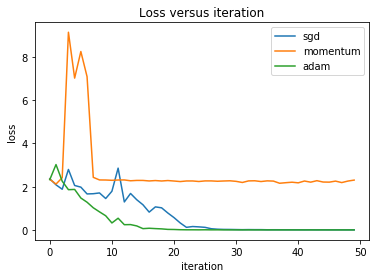

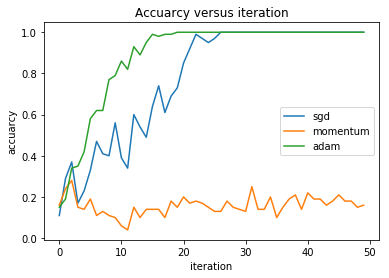

Optimizer: sgd, val loss = 4.7903643888078395, val acc = 0.197
Optimizer: momentum, val loss = 2.444997828501731, val acc = 0.119
Optimizer: adam, val loss = 7.252304020664882, val acc = 0.229


In [6]:
%matplotlib inline
%run train_optimizer.py

As shown above, adam not only converges faster, but also has a better validation accuracy.